In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

%matplotlib notebook
sns.set()

## Time it all

In [2]:
import galsim
from mdetsims import Sim
from mdetsims.metacal import MetacalTrueDetect, METACAL_TYPES
from mdetsims.defaults import TEST_METACAL_TRUEDETECT_CONFIG

In [22]:
# %%time

for i in range(2):
    rng = np.random.RandomState(seed=100)
    des_sim = Sim(
        rng=rng,
        g1=0.02 - i*0.04,
        gal_type='exp',
        scale=0.263,
        psf_type='gauss',
        n_coadd=30,
        n_coadd_psf=1,
        gal_grid=7)

    mbobs, tcat = des_sim.get_mbobs(return_truth_cat=True)
    mm = MetacalTrueDetect(TEST_METACAL_TRUEDETECT_CONFIG, mbobs, rng, tcat)
    mm.go()

     singular covariance
    pars at singular: -6.71e-10   3.6e-09  9.26e-08  -5.47e-08     0.304    0.0692 
     singular covariance
    pars at singular: -1.64e-09  -1.56e-08  2.46e-07  -2.76e-07     0.304    0.0692 


## Look at the Parts

In [23]:
import galsim
from mdetsims import Sim

In [24]:
des_sim = Sim(
    rng=np.random.RandomState(seed=100),
    g1=0.02,
    gal_type='exp',
    scale=0.263,
    psf_type='gauss',
    n_coadd=30,
    n_coadd_psf=1,
    gal_grid=7,
    gal_kws={'survey_name': 'DES'})

In [27]:
%%time

mbobs, tcat = des_sim.get_mbobs(return_truth_cat=True)

CPU times: user 193 ms, sys: 13.1 ms, total: 206 ms
Wall time: 209 ms


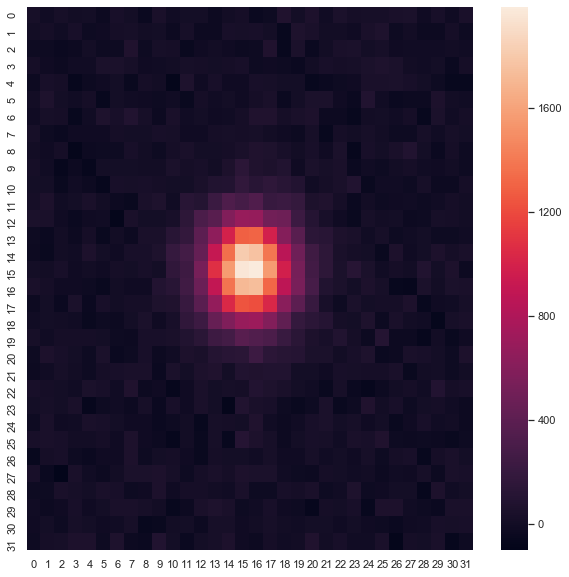

In [74]:
plt.figure(figsize=(10, 10))
sns.heatmap(mbobs[0][0].image)

## Run it all at once

In [29]:
%%time
rng = np.random.RandomState(seed=100)

mbobs, tcat = des_sim.get_mbobs(return_truth_cat=True)
mm = MetacalTrueDetect(TEST_METACAL_TRUEDETECT_CONFIG, mbobs, rng, tcat)
mm.go()

     singular covariance
    pars at singular: -1.91e-07  1.24e-09  1.19e-08  1.43e-07     0.304    0.0692 
     singular covariance
    pars at singular: 5.12e-07   5.6e-10  -3.65e-08  1.99e-07     0.304    0.0692 
     singular covariance
    pars at singular: 2.12e-09  1.44e-07  3.88e-08  4.98e-07     0.304    0.0692 
CPU times: user 7.66 s, sys: 1.43 s, total: 9.09 s
Wall time: 9.23 s


In [30]:
res = mm.result

In [34]:
def _mask(cat, s2n_cut, size_cut):
    return (cat['mcal_s2n'] > s2n_cut) & (cat['mcal_T_ratio'] > size_cut)

msks = {}
for sh in METACAL_TYPES:
    msks[sh] = _mask(res[sh], 10, 0.5)

In [35]:
g1_1p = np.mean(res['1p']['mcal_g'][msks['noshear'], 0])
g1_1m = np.mean(res['1m']['mcal_g'][msks['noshear'], 0])
R11 = (g1_1p - g1_1m) / 2 / 0.01

g2_2p = np.mean(res['2p']['mcal_g'][msks['noshear'], 1])
g2_2m = np.mean(res['2m']['mcal_g'][msks['noshear'], 1])
R22 = (g2_2p - g2_2m) / 2 / 0.01

g1_1p = np.mean(res['noshear']['mcal_g'][msks['1p'], 0])
g1_1m = np.mean(res['noshear']['mcal_g'][msks['1m'], 0])
R11_sel = (g1_1p - g1_1m) / 2 / 0.01

g2_2p = np.mean(res['noshear']['mcal_g'][msks['2p'], 1])
g2_2m = np.mean(res['noshear']['mcal_g'][msks['2m'], 1])
R22_sel = (g2_2p - g2_2m) / 2 / 0.01

R11 += R11_sel
R22 += R22_sel

In [36]:
R11, R22

(0.8908261620550594, 0.8965147130689336)

In [37]:
g1_1p = np.mean(res['1p']['mcal_g'][msks['1p'], 0])
g1_1m = np.mean(res['1m']['mcal_g'][msks['1m'], 0])
R11 = (g1_1p - g1_1m) / 2 / 0.01

g2_2p = np.mean(res['2p']['mcal_g'][msks['2p'], 1])
g2_2m = np.mean(res['2m']['mcal_g'][msks['2m'], 1])
R22 = (g2_2p - g2_2m) / 2 / 0.01

R11, R22

(0.8908261620550594, 0.8965147130689336)

## Run Detection

In [66]:
from mdetsims.metacal import TruthMEDSifier

tmbobs, tcat = des_sim.get_mbobs(return_truth_cat=True)
mfier = TruthMEDSifier(
    mbobs=tmbobs,
    meds_config=TEST_METACAL_TRUEDETECT_CONFIG['meds'],
    truth_cat=tcat)

In [67]:
mbmeds = mfier.get_multiband_meds()

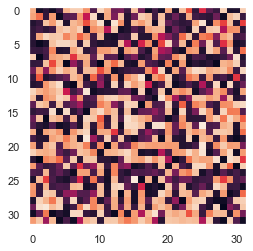

In [73]:
mbobs = mbmeds.get_mbobs(3)

plt.figure()
plt.imshow(np.arcsinh(mbobs[0][0].noise))
plt.gca().grid(False)